# Analysis 2
- Outcome: SCC
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [52]:
%load_ext rpy2.ipython 
# Load the R magic extension

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
from scipy.stats import percentileofscore
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path
from functools import reduce

In [54]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [55]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [56]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

In [57]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [58]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [59]:
univariate_filename = './../results/univariate_analysis_2_scc.csv'
multivariate_filename = './../results/multivariate_analysis_2_scc.csv'
risk_results_filename = './../results/risk_results_analysis_2_scc.csv'
risk_results_race_filename = './../results/risk_results_race_analysis_2_scc.csv'

In [60]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis - logistic regression

In [61]:
%%R
head(r_df_normal)

  ugica ugica_ESCC ugica_EAC ugica_CGC ugica_NCGC death subtype visit_year
1     0          0         0         0          0     0    <NA>       2011
2     0          0         0         0          0     0    <NA>       2011
3     0          0         0         0          0     0    <NA>       2011
4     0          0         0         0          0     0    <NA>       2011
5     0          0         0         0          0     1    <NA>       2011
6     0          0         0         0          0     0    <NA>       2011
  diagnosis_year            encounter_type    sex sex_missing
1             NA          Outpatient Visit   MALE        MALE
2             NA          Outpatient Visit   MALE        MALE
3             NA Hospital Outpatient Visit FEMALE      FEMALE
4             NA          Outpatient Visit   MALE        MALE
5             NA Inpatient Hospitalization FEMALE      FEMALE
6             NA          Outpatient Visit FEMALE      FEMALE
           race_clean race_clean_missing 

In [ ]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening",
    "hgball_baseline_imputed_mean", 'age_bucket', 'visit_year_bucket', 'meets_eac_screening'
)

subtype_outcomes <- c('ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC')

# Variables to do stratified analysis on 
cols_to_stratify <- c('race_clean', 'sex_missing', 'age_bucket', 'visit_year_bucket')

### Factorize categorical vars and set reference levels

In [101]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [102]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex"                           "sex_missing"                  
 [3] "race_clean"                    "race_clean_missing"           
 [5] "ethnicity"                     "ethnicity_missing"            
 [7] "alcohol_all"                   "alcohol_binary"               
 [9] "tobacco_all"                   "tobacco_all_missing"          
[11] "tobacco_binary"                "tobacco_binary_missing"       
[13] "hpylori_active"                "hpylori_active_chronic"       
[15] "hpylori_active_chronic_binary" "hnca"                         
[17] "achalasia"                     "pud"                          
[19] "gerd"                          "cad"                          
[21] "barretts"                      "famhx_cancer"                 
[23] "famhx_esophagealca"            "famhx_gastricca"              
[25] "famhx_colonca"                 "famhx_barretts"               
[27] "ASA"                           "PPI"                          
[29] "NSAID"                      

In [66]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("ugica_ESCC ~", i))
    
    model <- glm(formula, data=r_df_normal, family = binomial)

    model_summary <- summary(model)

    # Get odds ratios and confidence intervals
    coef <- exp(coef(model))
    confint_vals <- exp(confint(model))  # 95% CI for log-odds, exponentiated to OR
    p_value <- coef(summary(model))[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(coef(summary(model)))

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        OR = coef[terms],
        CI_lower = confint_vals[terms, 1],
        CI_upper = confint_vals[terms, 2],
        p_value = p_value[terms]
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [67]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [68]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex.(Intercept),sex,(Intercept),0.000032,0.000022,0.000045,0.000000e+00
3,sex_missing.(Intercept),sex_missing,(Intercept),0.000032,0.000022,0.000045,0.000000e+00
5,race_clean.(Intercept),race_clean,(Intercept),0.000038,0.000025,0.000055,0.000000e+00
10,race_clean_missing.(Intercept),race_clean_missing,(Intercept),0.000038,0.000025,0.000055,0.000000e+00
14,ethnicity.(Intercept),ethnicity,(Intercept),0.000052,0.000038,0.000068,0.000000e+00
16,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.120225,0.036242,0.295605,4.817062e-05
17,ethnicity_missing.(Intercept),ethnicity_missing,(Intercept),0.000052,0.000038,0.000068,0.000000e+00
19,alcohol_all.(Intercept),alcohol_all,(Intercept),0.000016,0.000006,0.000035,3.381295e-134
20,alcohol_all.alcohol_all1.0,alcohol_all,1.0,5.252116,1.460650,18.885247,8.723378e-03
21,alcohol_all.alcohol_all2.0,alcohol_all,2.0,3.332556,1.305487,10.189629,1.878501e-02


## Feature selection

In [103]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

duplicate_vars <- c("alcohol_all", "tobacco_all", "tobacco_all_missing", "tobacco_binary_missing", "barretts")
selected_vars <- selected_vars[
    !selected_vars %in% duplicate_vars &
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "ethnicity"       "alcohol_binary"  "tobacco_binary"  "hnca"           
 [5] "pud"             "gerd"            "cad"             "famhx_cancer"   
 [9] "famhx_gastricca" "famhx_colonca"   "ASA"             "PPI"            
[13] "NSAID"           "age"            


### Forest plot for univariate visualization

In [104]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

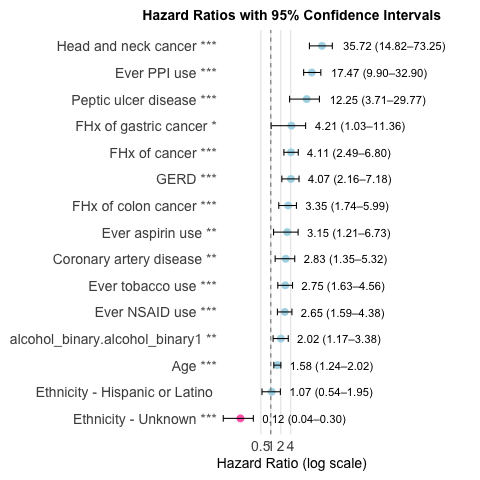

In [105]:
%%R 
pretty_names <- c(
"PPI.PPI1" = "Ever PPI use",
"pud.pud1" = "Peptic ulcer disease",
"hnca.hnca1" = "Head and neck cancer",
"cad.cad1" = "Coronary artery disease", 
"gerd.gerd1" = "GERD",
"famhx_cancer.famhx_cancer1" = "FHx of cancer",
"famhx_gastricca.famhx_gastricca1" = "FHx of gastric cancer",
"ASA.ASA1" = "Ever aspirin use",
"sex_missing.sex_missingMALE" = "Sex - Male",
"tobacco_binary.tobacco_binary1" = "Ever tobacco use",
"NSAID.NSAID1" = "Ever NSAID use",
"age.age" = "Age",
"famhx_colonca.famhx_colonca1" = "FHx of colon cancer",
"ethnicity.ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_clean.race_cleanAsian" = "Race - Asian",
"race_clean.race_cleanBlack or African American" = "Race - Black or African American",
"race_clean.race_cleanOther" = "Race - Other",
"race_clean.race_cleanNA" = "Race - Unknown",
"ethnicity.ethnicityNo matching concept" = "Ethnicity - Unknown"
)

# Define color and label formatting
forestplot_df <- forestplot_df %>%
  mutate(
    Variable_pretty = pretty_names[Variable_full],
    Variable_pretty = ifelse(is.na(Variable_pretty), Variable_full, Variable_pretty),
    sig = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    or_label = sprintf("%.2f (%.2f–%.2f)", OR, CI_lower, CI_upper),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(OR >= 1, "OR > 1", "OR < 1")
  ) %>%
  arrange(OR) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(forestplot_df, aes(x = OR, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = CI_lower, xmax = CI_upper), height = 0.25) +
  geom_text(aes(x = CI_upper * 1.05, label = or_label), hjust = -0.1, size = 4) +  # Shows OR + CI
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  coord_cartesian(clip = "off") + 
  scale_color_manual(
    values = c("OR > 1" = "lightblue", "OR < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4"),
    expand = expansion(mult = c(0, 0.25))  # Make room for right-side labels
  ) +
  labs(
    title = "Hazard Ratios with 95% Confidence Intervals",
    x = "Hazard Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    plot.title.position = "panel",
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank(),
    plot.margin = margin(10, 120, 10, 10)  # top, right, bottom, left (in pts)
  )



## Logistic regression multivariate model training

In [106]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(subtype_outcomes), all_of(selected_vars), all_of(cols_to_stratify)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica_ESCC, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica_ESCC' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica_ESCC)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica_ESCC)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica_ESCC)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = glm) {
  formula_str <- paste("ugica_ESCC ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set, family = binomial)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(logreg_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    logreg_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      OR_scaled = estimate / min(estimate, na.rm = TRUE),
      OR_rank = round(OR_scaled)
  )

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(model, validation_set) {  
  risk <- predict(model, newdata = validation_set, type = "response")
  return(risk)
}

# Gets actual event 
count_event <- function(validation_set, outcome, horizon_months = 60) {
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set[[outcome]] == 1)
  return(event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk, quiet = TRUE)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 3)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "navyblue", size = 1.2) +  # Better color
    geom_abline(linetype = "dashed", color = "gray50") +
    annotate("text", x = 0.65, y = 0.05, label = paste("AUROC =", auroc),
             size = 5, hjust = 0, fontface = "italic") +
    labs(
      title = "Receiver Operating Characteristic (ROC) Curve",
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)"
    ) +
    coord_equal() +
    theme_minimal(base_size = 16) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),
      axis.title = element_text(face = "bold"),
      panel.grid.minor = element_blank(),
      plot.margin = margin(10, 60, 10, 10)  # top, right, bottom, left (in pts)
    )
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


#### Split dataset into training and validation

In [107]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_model(train_set, selected_vars, model_func=glm)

[1] "Dataset Controls 34122" "Dataset Cases 61"      
[1] "Training Controls 27304" "Training Cases 43"      
[1] "Validation Controls 6818" "Validation Cases 18"     



#### Multivariate analysis

In [108]:
%%R 
# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(logreg_model, multivariate_filename, variable_labels)


Multivariate results saved to ./../results/multivariate_analysis_2_scc.csv 


In [109]:
%%R 
names(multivariate_df)

 [1] "term"           "variable"       "var_label"      "var_class"     
 [5] "var_type"       "var_nlevels"    "contrasts"      "contrasts_type"
 [9] "reference_row"  "label"          "n_obs"          "n_event"       
[13] "estimate"       "std.error"      "statistic"      "p.value"       
[17] "conf.low"       "conf.high"      "OR_scaled"      "OR_rank"       


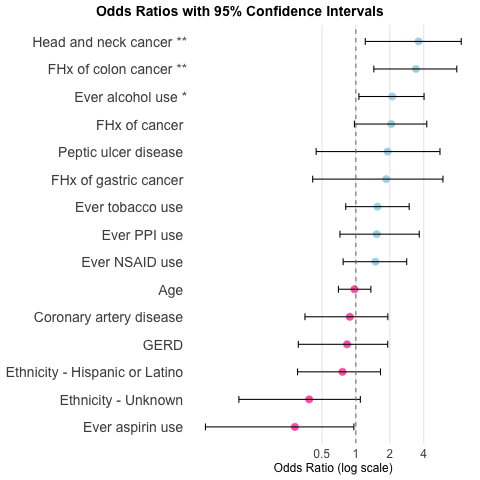

In [110]:
%%R 
pretty_names <- c(
"ethnicityNo matching concept" = "Ethnicity - Unknown",
"alcohol_all2.0" = "Alcohol Use - Current",
"alcohol_all1.0" = "Alcohol Use - Prior",
"alcohol_allNo matching concept" = "Alcohol Use - Unknown",
"ASA1" = "Ever aspirin use",
"tobacco_binary1.0" = "Ever tobacco use",
"NSAID1" = "Ever NSAID use",
"hgb_imputed_scaled" = "Most recent hemoglobin",
"race_cleanOther" = "Race - Other",
"race_cleanNA" = "Race - Unknown",
"ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_cleanBlack or African American" = "Race - Black or African American",
"age_scaled" = "Age",
"alcohol_binary_missing:tobacco_binary1.0" = "Alcohol + tobacco use interaction",
"race_cleanAsian" = "Race - Asian",
"race_cleanNo matching concept" = "Race - Unknown",
"sex_missingMALE" = "Sex - Male",
"famhx_gastricca1" = "FHx of gastric cancer",
"hpylori_binary1.0" = "Active or chronic H.pylori infection",
"PPI1" = "Ever PPI use",
"barretts1" = "Barretts esophagus",
"cad1" = "Coronary artery disease", 
"famhx_cancer1" = "FHx of cancer",
"famhx_colonca1" = "FHx of colon cancer",
"gerd1" = "GERD",
"pud1" = "Peptic ulcer disease",
"hnca1" = "Head and neck cancer",
"alcohol_binary1" = "Ever alcohol use",
"tobacco_binary1" = "Ever tobacco use",
"age" = "Age"
)

# Define color and label formatting
multivariate_df <- multivariate_df %>%
  filter(statistic != 0) %>%
  mutate(
    Variable_pretty = pretty_names[term],
    Variable_pretty = ifelse(is.na(Variable_pretty), term, Variable_pretty),
    sig = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    or_label = sprintf("%.2f (%.2f–%.2f)", estimate, conf.low, conf.high),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(estimate >= 1, "estimate > 1", "estimate < 1")
  ) %>%
  arrange(estimate) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(multivariate_df, aes(x = estimate, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.25) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  scale_color_manual(
    values = c("estimate > 1" = "lightblue", "estimate < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4")
  ) +
  labs(
    title = "Odds Ratios with 95% Confidence Intervals",
    x = "Odds Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    plot.title.position = "plot",             # Title alignment
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),  # Centered title
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank()
  )


In [111]:
%%R 
# Convert all factor columns in validation_set to character
validation_set[] <- lapply(validation_set, function(x) {
  if (is.factor(x)) as.character(x) else x
})

## Results

### Predict events

In [112]:
%%R 
head(validation_set)

   months_to_event ugica ugica_ESCC ugica_EAC ugica_CGC ugica_NCGC
6        59.071869     0          0         0         0          0
12        4.993840     0          0         0         0          0
14       66.726899     0          0         0         0          0
23      157.043121     0          0         0         0          0
25        0.164271     0          0         0         0          0
29      110.948665     0          0         0         0          0
                ethnicity alcohol_binary tobacco_binary hnca pud gerd cad
6     No matching concept              0              0    0   0    0   0
12    No matching concept              0              0    0   0    1   0
14 Not Hispanic or Latino              1              1    0   0    1   0
23     Hispanic or Latino              0              0    0   0    0   0
25 Not Hispanic or Latino              1              1    0   0    0   0
29     Hispanic or Latino              0              0    0   0    0   0
   famhx_canc

In [113]:
%%R 
# Estimate risk
risk_5_years <- calculate_risk(logreg_model, validation_set)
event_5_years <- count_event(validation_set, "ugica_ESCC")

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event_escc = validation_set$ugica_ESCC,
    race = validation_set$race_clean,
    pred_risk = risk_5_years,
    escc_5yr = event_5_years
)

# # Convert variable from int to character before transfer to python
# r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])

# # Set risk threshold to calculate sensitivity and specificity
# percentile = 70
# cat("\nSensitivity and Metrics at 70% Specificity")
# threshold <- quantile(risk_5_years, probs = percentile / 100)
# calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)

### Sensitivity and Metrics at threshold that maximizes Youdens

In [114]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.636 
Sensitivity: 0.6666667 
Specificity: 0.6652995 
PPV: 0.002618944 
NPV: 0.9993399 
NNS: 510.4964 
     predicted_class
event    0    1
    0 4542 2285
    1    3    6


### AUROC curves and PR curve

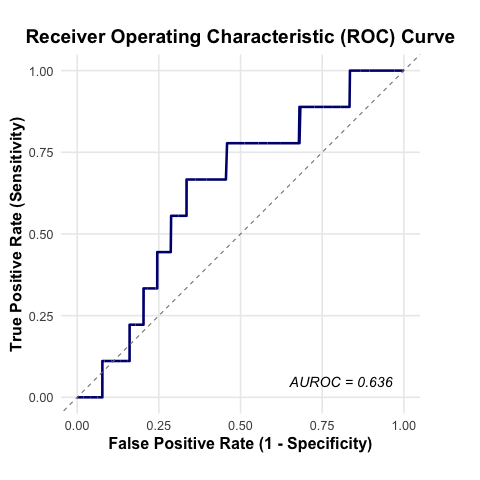

In [115]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

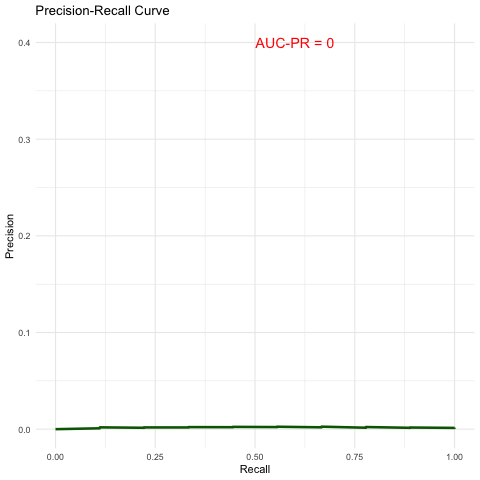

In [116]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [117]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk['pred_risk'], optimal_threshold, kind='weak')/100.

df_validation_risk['actual_percentile'] = df_validation_risk.pred_risk.apply(lambda x: percentileofscore(df_validation_risk['pred_risk'], x, kind='weak')/100.)

# Example inputs
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]
percentile_cutoffs_sorted = sorted(set(percentile_cutoffs))
percentile_high_risk = 0.9 # Chosen percentile for high risk group, can vary to compare  

labels = percentile_cutoffs_sorted[:-1]

# Assign risk groups based on custom percentile cutoffs
df_validation_risk['risk_group'] = pd.qcut(
    df_validation_risk['pred_risk'],
    q=percentile_cutoffs_sorted,
    labels=labels,
    duplicates='drop'  # in case there are tied values
)

# One-hot encoding, create a boolean column for each percentile cutoff
for idx, label in enumerate(labels):
    risk_col = f"risk_p{percentile_cutoffs_sorted[idx+1]}"
    include_labels = labels[:idx+1]
    df_validation_risk[risk_col] = np.where(df_validation_risk['risk_group'].isin(include_labels), 0, 1)

# Custom low/high risk cutoff
high_risk_idx = percentile_cutoffs_sorted.index(percentile_high_risk)
df_validation_risk['high_risk'] = np.where(df_validation_risk['risk_group'] == labels[high_risk_idx], 1, 0)

# Optimal Youden threshold cutoff
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk['pred_risk'] >= optimal_threshold, 1, 0)


In [118]:
def classification_metrics(predicted_risk_df, risk_group_name, actual_event_name, race = 'all'):
    predicted_class = predicted_risk_df[risk_group_name]
    actual_class = predicted_risk_df[actual_event_name]

    # Get confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    total_in_risk_group = predicted_class.sum() #tp+fp
    total_cases_in_risk_group = tp
    prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1) 

    # Return as dictionary
    return {
        "risk_group": risk_group_name,
        "risk_percentile": float(risk_group_name[6:]) if risk_group_name[0:6] == 'risk_p' else optimal_threshold_percentile, # Get the percentile appended to the end of the risk group name unless youden
        "event": actual_event_name,
        "race": race,
        "actual controls": fp+tn,
        "actual cases": tp+fn,
        "total pts in risk group": total_in_risk_group,
        "cancer prevalence in risk group": f'{total_cases_in_risk_group} ({prevalence_in_risk_group}%)',
        "prevalence": prevalence_in_risk_group,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "pred correct": (tp+tn)/(tp+fp+fn+tn),
        "pred incorrect": (fp+fn)/(tp+fp+fn+tn),
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [119]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['escc_5yr']
race_groups = df_validation_risk.race.unique()

results_by_riskgroup = []
results_by_race = []

for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_by_riskgroup.append(row)

for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", "escc_5yr", race)
    results_by_race.append(row)

df_results = pd.DataFrame(results_by_riskgroup)
df_results_race = pd.DataFrame(results_by_race)

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_41685/3572402086.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)


#### Metrics for each percentile and cancer subtype, ordered by percentile

In [120]:
df_results.tail()

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
7,risk_p0.95,0.950000,escc_5yr,all,6827,9,342,0 (0.0%),0.0,0,342,9,6485,0.948654,0.051346,0.000000,94.990479,0.000000,99.861411,-0.050095
8,risk_p0.975,0.975000,escc_5yr,all,6827,9,171,0 (0.0%),0.0,0,171,9,6656,0.973669,0.026331,0.000000,97.495239,0.000000,99.864966,-0.025048
9,risk_p0.99,0.990000,escc_5yr,all,6827,9,69,0 (0.0%),0.0,0,69,9,6758,0.988590,0.011410,0.000000,98.989307,0.000000,99.867002,-0.010107
10,risk_p1,1.000000,escc_5yr,all,6827,9,0,0 (nan%),NaN,0,0,9,6827,0.998683,0.001317,0.000000,100.000000,0.000000,99.868344,0.000000
11,risk_p0.6648624926857812,0.664862,escc_5yr,all,6827,9,2291,6 (0.3%),0.3,6,2285,3,4542,0.665301,0.334699,66.666667,66.529955,0.261894,99.933993,0.331966


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [121]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,risk_p0.5,0.500000,escc_5yr,all,6827,9,3411,7 (0.2%),0.2,7,3404,2,3423,0.501755,0.498245,77.777778,50.139153,0.205218,99.941606,0.279169
1,risk_p0.6,0.600000,escc_5yr,all,6827,9,2732,6 (0.2%),0.2,6,2726,3,4101,0.600790,0.399210,66.666667,60.070309,0.219619,99.926901,0.267370
11,risk_p0.6648624926857812,0.664862,escc_5yr,all,6827,9,2291,6 (0.3%),0.3,6,2285,3,4542,0.665301,0.334699,66.666667,66.529955,0.261894,99.933993,0.331966
2,risk_p0.7,0.700000,escc_5yr,all,6827,9,2050,5 (0.2%),0.2,5,2045,4,4782,0.700263,0.299737,55.555556,70.045408,0.243902,99.916423,0.256010
3,risk_p0.75,0.750000,escc_5yr,all,6827,9,1709,4 (0.2%),0.2,4,1705,5,5122,0.749854,0.250146,44.444444,75.025634,0.234055,99.902477,0.194701
4,risk_p0.8,0.800000,escc_5yr,all,6827,9,1362,2 (0.1%),0.1,2,1360,7,5467,0.800029,0.199971,22.222222,80.079098,0.146843,99.872123,0.023013
5,risk_p0.85,0.850000,escc_5yr,all,6827,9,1026,1 (0.1%),0.1,1,1025,8,5802,0.848888,0.151112,11.111111,84.986085,0.097466,99.862306,-0.039028
6,risk_p0.9,0.900000,escc_5yr,all,6827,9,684,1 (0.1%),0.1,1,683,8,6144,0.898917,0.101083,11.111111,89.995606,0.146199,99.869961,0.011067
7,risk_p0.95,0.950000,escc_5yr,all,6827,9,342,0 (0.0%),0.0,0,342,9,6485,0.948654,0.051346,0.000000,94.990479,0.000000,99.861411,-0.050095
8,risk_p0.975,0.975000,escc_5yr,all,6827,9,171,0 (0.0%),0.0,0,171,9,6656,0.973669,0.026331,0.000000,97.495239,0.000000,99.864966,-0.025048


In [122]:
df_results.to_csv(risk_results_filename)

### Performance metrics by race at the optimal risk percentile

In [123]:
df_results_race

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,high_risk_youden,0.664862,escc_5yr,No matching concept,2335,3,548,2 (0.4%),0.4,2,546,1,1789,0.766039,0.233961,66.666667,76.616702,0.364964,99.944134,0.432834
1,high_risk_youden,0.664862,escc_5yr,White,2527,5,1004,3 (0.3%),0.3,3,1001,2,1526,0.603870,0.396130,60.000000,60.387812,0.298805,99.869110,0.203878
2,high_risk_youden,0.664862,escc_5yr,Black or African American,1476,0,580,0 (0.0%),0.0,0,580,0,896,0.607046,0.392954,0.000000,60.704607,0.000000,100.000000,-0.392954
3,high_risk_youden,0.664862,escc_5yr,Asian,275,1,95,1 (1.1%),1.1,1,94,0,181,0.659420,0.340580,100.000000,65.818182,1.052632,100.000000,0.658182
4,high_risk_youden,0.664862,escc_5yr,Other,214,0,64,0 (0.0%),0.0,0,64,0,150,0.700935,0.299065,0.000000,70.093458,0.000000,100.000000,-0.299065


In [124]:
df_results_race.to_csv(risk_results_race_filename)

### Prevalance of cancer as a function of risk percentile by subtype

In [125]:
event_pretty_label = {
    "ugica_5yr": "UGI cancer", 
    "escc_5yr": "Esophageal SCC",
    "eac_5yr": "Esophageal AC",
    "cgc_5yr": "Cardia Gastric AC",
    "ncgc_5yr": "Noncardia Gastric AC"
}

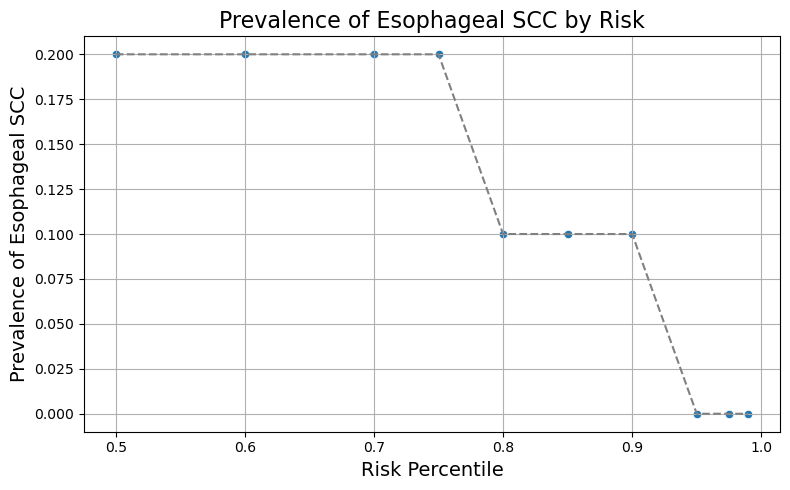

In [126]:
df_results_plot = df_results[df_results['risk_percentile'] != optimal_threshold_percentile]

for event in events_5yr:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')


    # Axis labels and title
    plt.xlabel("Risk Percentile", fontsize=14)
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}', fontsize=14)
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Save model, threshold and validation set

In [127]:
%%R 
# Save model
saveRDS(logreg_model, "logreg_escc.rds")

In [128]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [129]:
model = 'logreg'
subtype = 'escc'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
